# Prediction Comparison for UNet Versions

This plots the model segmentation predictions versus the ground truth.

We need to compare the model outputs based on doing the **up sampling operation** via:
+ [UpSampling2D](https://keras.io/layers/convolutional/#upsampling2d)
   ```
   up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=-1)
   ```
+ [Conv2DTranspose](https://keras.io/layers/convolutional/#conv2dtranspose)
   ```
   up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=-1)
   ```
   
Intel has optimized the operations for Conv2DTranspose but not for UpSampling2D. If we can prove that the two produce similar results, then we can recommend the Intel optimization as a viable substitution.

In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def dice(im1, im2):
    
    '''
    Do we match the binary version of the prediction mask or the probability version?
    '''
    
    im1 = np.asarray(im1)
    im2 = np.asarray(im2)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    # Compute Dice coefficient
    intersection = im1*im2

    smoothing_delta = 1e-7
    
    return (2. * intersection.sum() + smoothing_delta) / (im1.sum() + im2.sum() + smoothing_delta)

# Loading the prediction masks and the ground truth data

The *pred.npy* files were generated by running:
```
numactl -p 1 python train.py 50 5 0
```

In [3]:
msk_upsampling = np.load('msks_pred_upsampling.npy')
msk_transposed = np.load('msks_pred_transposed.npy')
dir1 = '/mnt/data/medical/brats/all_slices/Results/'
test = np.load(dir1+'msks_test.npy')
imgs = np.load(dir1+'imgs_test.npy')

In [4]:
# Preprocess the segmentation masks for the ground truth (mode=1)
test[:,:,:,0] = test[:,:,:,0]+test[:,:,:,1]+test[:,:,:,2]+test[:,:,:,3]

In [5]:
def comparePredictions(img):
    
    plt.figure(figsize=(14,14))
    plt.subplot(1,4,1)
    plt.imshow(msk_upsampling[img,:,:,0], cmap='bone')
    plt.title('Prediction UpSampling')
    plt.subplot(1,4,2)
    plt.imshow(msk_transposed[img,:,:,0], cmap='bone')
    plt.yticks([])
    plt.title('Prediction Transposed')
    plt.subplot(1,4,3)
    plt.imshow(test[img,:,:,0], cmap='bone')
    plt.yticks([])
    plt.title('Ground truth');
    plt.subplot(1,4,4)
    plt.imshow(imgs[img,:,:,0]);
    plt.imshow(test[img,:,:,0], alpha=0.5);
    plt.yticks([])
    plt.title('Image with mask')
    
    # Calculate the Dice coefficient for the two versions
    msk_binaryU = msk_upsampling[img,:,:,0]
    print ('Dice coefficient for upsampling {}'.format(dice(msk_binaryU, test[img,:,:,0])))
    
    msk_binaryT = msk_transposed[img,:,:,0]
    print ('Dice coefficient for transposed {}'.format(dice(msk_binaryT, test[img,:,:,0])))
    

Dice coefficient for upsampling 0.904381538967
Dice coefficient for transposed 0.840180254057


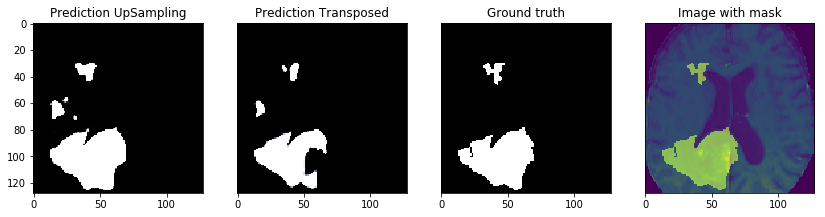

In [6]:
comparePredictions(5821)

Dice coefficient for upsampling 0.877796360873
Dice coefficient for transposed 0.874398650188


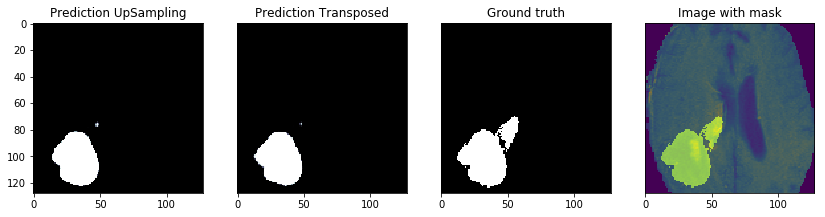

In [7]:
comparePredictions(400)

Dice coefficient for upsampling 0.833969745546
Dice coefficient for transposed 0.870109655554


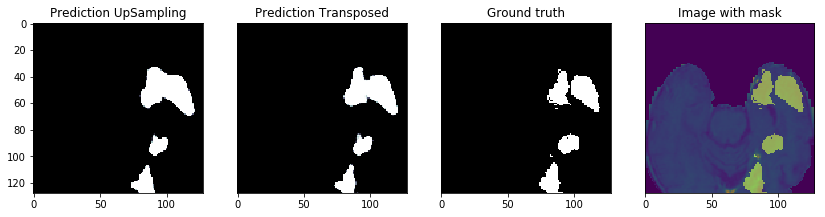

In [8]:
comparePredictions(520)

Dice coefficient for upsampling 0.976872066987
Dice coefficient for transposed 0.96831117485


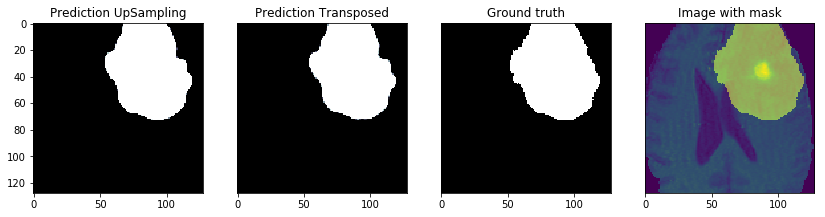

In [9]:
comparePredictions(1333)

Dice coefficient for upsampling 0.922456580716
Dice coefficient for transposed 0.90323783282


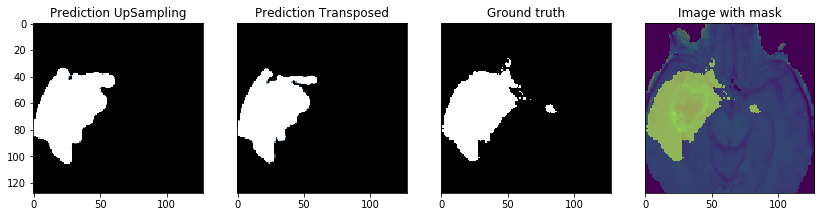

In [10]:
comparePredictions(2540)

Dice coefficient for upsampling 0.713838365435
Dice coefficient for transposed 0.596886160332


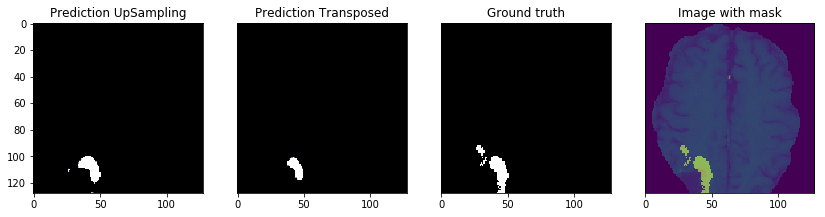

In [11]:
comparePredictions(5533)

Dice coefficient for upsampling 0.933191196108
Dice coefficient for transposed 0.938840694531


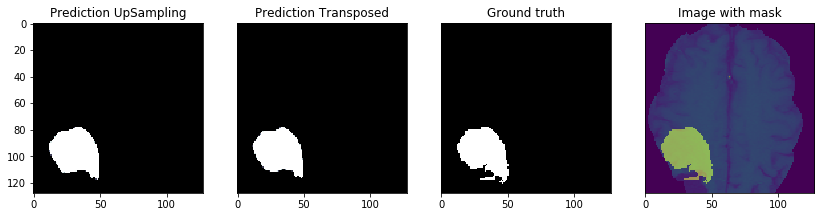

In [12]:
comparePredictions(2121)

Dice coefficient for upsampling 0.936543119844
Dice coefficient for transposed 0.933819035496


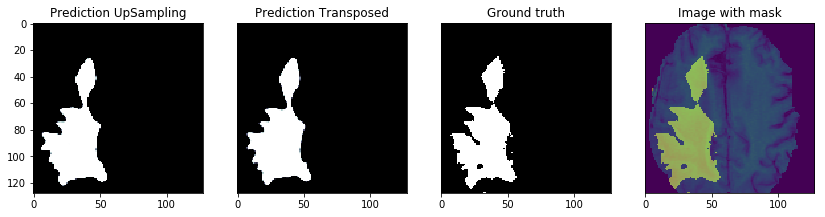

In [13]:
comparePredictions(4444)

Dice coefficient for upsampling 0.822204271487
Dice coefficient for transposed 0.831734561804


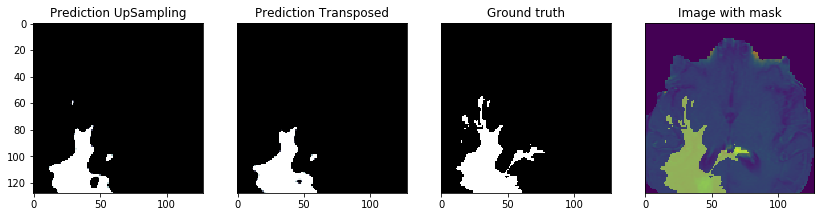

In [14]:
comparePredictions(3334)

Dice coefficient for upsampling 0.897452409676
Dice coefficient for transposed 0.790657765251


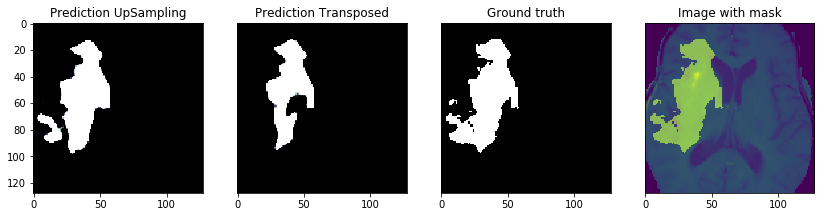

In [15]:
comparePredictions(2560)

Dice coefficient for upsampling 0.0554274561423
Dice coefficient for transposed 0.0303689191911


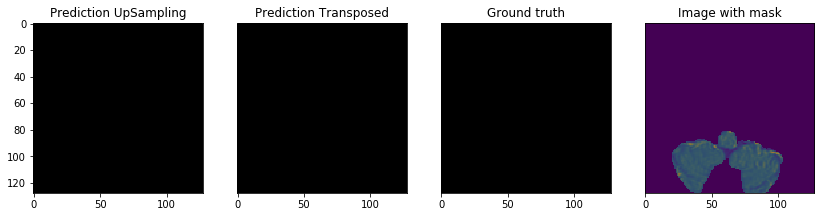

In [16]:
comparePredictions(10)

Dice coefficient for upsampling 0.0618533536685
Dice coefficient for transposed 9.483057051e-11


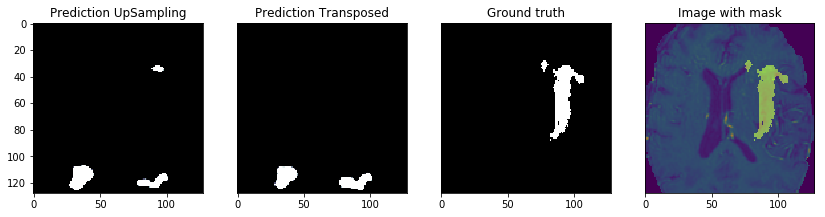

In [17]:
comparePredictions(88)

Dice coefficient for upsampling 0.0550523095053
Dice coefficient for transposed 0.0303403011368


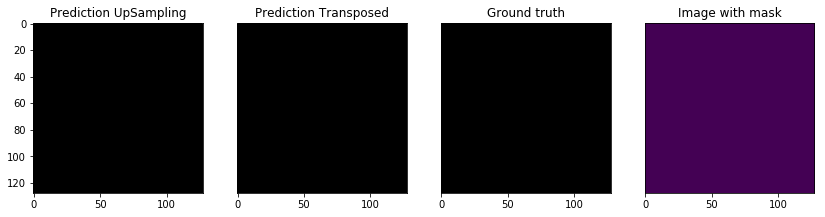

In [18]:
comparePredictions(150)

Dice coefficient for upsampling 0.710962553307
Dice coefficient for transposed 3.74019504946e-09


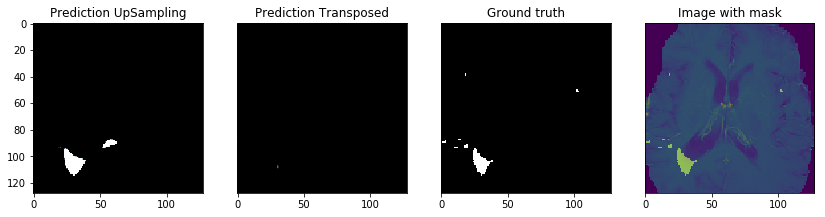

In [19]:
comparePredictions(231)

In [20]:
dice_transposed = np.zeros(test.shape[0])
dice_upsampling = np.zeros(test.shape[0])
mass = np.zeros(test.shape[0])

for i in range(test.shape[0]):
    
    dice_transposed[i] = dice(msk_transposed[i, :, :, 0], test[i, :, :, 0])
    dice_upsampling[i] = dice(msk_upsampling[i, :, :, 0], test[i, :, :, 0])
    mass[i] = np.sum(test[i, :, :, 0]) # The amount of tumor pixels in the image
    

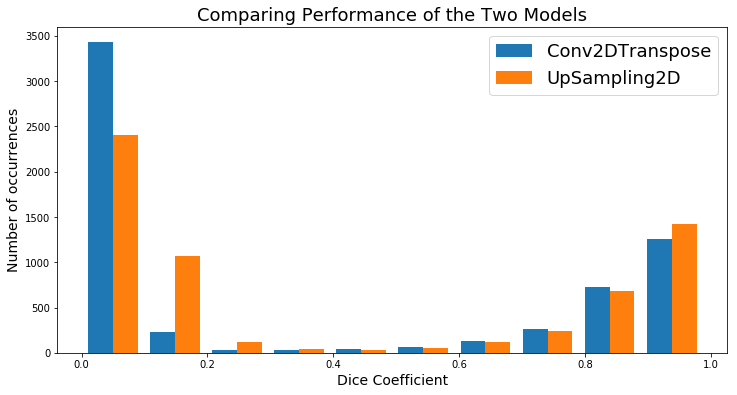

In [21]:
plt.figure(figsize=(12,6));
plt.hist([dice_transposed, dice_upsampling]);
plt.legend(['Conv2DTranspose', 'UpSampling2D'], fontsize=18);
plt.title('Comparing Performance of the Two Models', fontsize=18);
plt.xlabel('Dice Coefficient', fontsize=14);
plt.ylabel('Number of occurrences', fontsize=14);

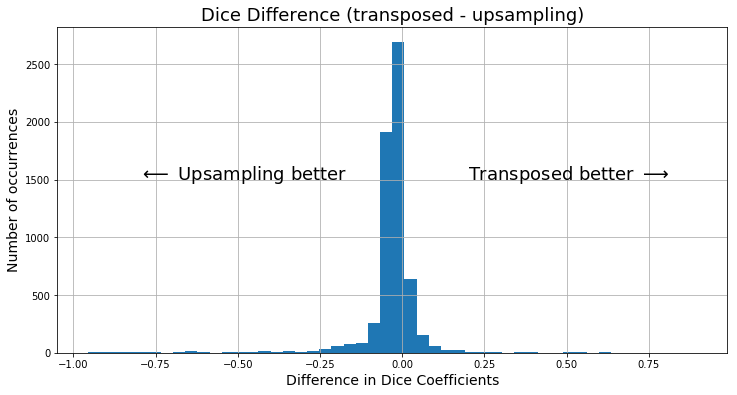

In [26]:
plt.figure(figsize=(12,6));
plt.hist(dice_transposed - dice_upsampling, 50);
plt.title('Dice Difference (transposed - upsampling)', fontsize=18);
plt.text(0.2, 1500, r'Transposed better $\longrightarrow$', fontsize=18);
plt.text(-.8, 1500, r'$\longleftarrow$ Upsampling better', fontsize=18);
plt.xlabel('Difference in Dice Coefficients', fontsize=14);
plt.ylabel('Number of occurrences', fontsize=14)
plt.grid();

# Kolmogorov-Smirnoff (KS) Test

Perform a [Kolmogorov-Smirnov](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test#Two-sample_Kolmogorov.E2.80.93Smirnov_test) two sample test. The null hypothesis is that the two data samples come from the same distribution. 

In [23]:
from scipy.stats import ks_2samp

ks_2samp(dice_transposed, dice_upsampling)

Ks_2sampResult(statistic=0.21709677419354842, pvalue=6.889868769315524e-128)

# Two-sided t-Test

Check if the difference between the Dice measures for each prediction is significantly different from 0.

In [30]:
from scipy.stats import ttest_1samp

ttest_1samp(dice_transposed-dice_upsampling, 0)

Ttest_1sampResult(statistic=-22.727849879099917, pvalue=6.6436490627283865e-110)

In [32]:
np.mean(dice_transposed)

0.37599964003684511

In [33]:
np.mean(dice_upsampling)

0.40706962188446288

# Where are most of the poor predictions coming from?

It looks like when the Dice coefficient is low that typically there is not enough of a segmentation mask to make a sufficiently good prediction. To measure this, I calculated the "mass" of the segmentation map (i.e. just counted how many pixels were in the mask). Low dice scores were highly correlated with smaller segmentation masks.

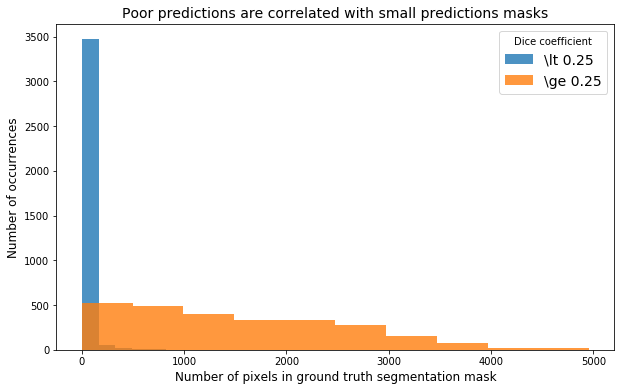

In [24]:
plt.figure(figsize=(10,6))
plt.hist(mass[np.where(dice_upsampling < 0.25)], bins=10, alpha=0.8);
plt.hist(mass[np.where(dice_upsampling >= 0.25)], bins=10, alpha=0.8);
plt.title('Poor predictions are correlated with small predictions masks', fontsize=14);
plt.ylabel('Number of occurrences', fontsize=12);
plt.xlabel('Number of pixels in ground truth segmentation mask', fontsize=12);
plt.legend(['\lt 0.25', '\ge 0.25'], title='Dice coefficient', fontsize=14);